# Metadata Extraction and Analysis

## Imports and dataloading

In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm

# Statistical imports
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm

from utils import *

In [2]:
import sys
sys.path.append('/users/wojemann/iEEG_processing')
from pioneer import Pioneer

In [3]:
usr,passpath,datapath,prodatapath,figpath,patient_table,rid_hup,pt_list = \
load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'),'HUP')

In [4]:
patient_table

,ptID,ieeg_ids,lf_stim,hf_stim,typical,mtle,focality,laterality,interictal_training
13,HUP224,"[HUP224_phaseII, HUP224_CCEP]",1,0,0.0,1.0,1.0,2.0,"[HUP224_phaseII, 5915]"
14,HUP225,"[HUP225_phaseII, HUP225_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP225_phaseII, 71207]"
15,HUP229,"[HUP229_phaseII, HUP229_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP229_phaseII, 149146]"
16,HUP230,"[HUP230_phaseII, HUP230_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP230_phaseII, 25350]"
17,HUP235,"[HUP235_phaseII, HUP235_CCEP]",1,1,1.0,1.0,0.0,0.0,"[HUP235_phaseII, 307651]"
18,HUP238,"[HUP238_phaseII, HUP238_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP238_phaseII, 100011]"
19,HUP246,"[HUP246_phaseII, HUP246_CCEP]",1,0,1.0,1.0,0.0,0.0,"[HUP246_phaseII, 100000]"
20,HUP247,"[HUP247_phaseII, HUP247_CCEP]",1,0,1.0,0.0,0.0,1.0,"[HUP247_phaseII, 17590]"
21,HUP249,"[HUP249_phaseII, HUP249_CCEP]",1,0,0.0,0.0,1.0,2.0,"[HUP249_phaseII, 24112]"
22,HUP250,"[HUP250_phaseII, HUP250_CCEP]",1,0,1.0,0.0,2.0,3.0,"[HUP250_phaseII, 24841]"


## Creating annotation assignments

In [5]:
seizures_df = pd.read_csv(ospj(datapath,'stim_seizure_information - LF_seizure_annotation.csv'))
seizures_df = seizures_df[~seizures_df.Patient.isin(["HUP235","HUP238","HUP246","HUP261"])]
seizures_df = seizures_df[seizures_df['to_annotate']==1]
seizures_df['annotators'] = ""
seizures_df['approximate_onset'].fillna(seizures_df['UEO'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['EEC'],inplace=True)
seizures_df['approximate_onset'].fillna(seizures_df['Other_onset_description'],inplace=True)
seizures_df = seizures_df.drop(['to_annotate','Notes','source','EEC onset channels','UEO onset channels','EEC','UEO','Other_onset_description'],axis=1).reset_index(drop=True)
seizures_df.head()

,Patient,IEEGname,approximate_onset,end,stim,stim_channels,annotators
0,HUP224,HUP224_phaseII,71156.5900,71190.99,1.0,LB1-LB2,
1,HUP224,HUP224_phaseII,339143.6435,339234.20,0.0,NaN,
2,HUP224,HUP224_phaseII,491467.8046,491541.43,0.0,NaN,
3,HUP224,HUP224_phaseII,519177.9500,519258.16,0.0,NaN,
4,HUP225,HUP225_phaseII,159834.1400,159913.05,1.0,RC1-RC2,


In [6]:
# Assuming you have a DataFrame named 'seizures_df' containing seizure data
# And a list of annotators initials 2,5
np.random.seed(10)
annotators = ['CK','EC','DZ','JJ','JK']
annotation_counts = {key: 0 for key in annotators}
def calc_weights(annotation_counts):
    weights = [1/(1+value) for value in annotation_counts.values()]
    tot_weight = sum(weights)
    return [w/tot_weight for w in weights]

# Assuming 'seizures_df' contains a column 'patient_id' indicating the patient ID for each seizure
# We'll first group seizures by patient_id
grouped_seizures = seizures_df.groupby('Patient')

# Dictionary to store DataFrames for each annotator
annotator_dfs = {}

# Create Primary DF that contains all seizures from all patients with all annotators per seizure
# Iterate over each patient group
for patient_id, patient_group in grouped_seizures:
    num_seizures = len(patient_group)
    # Randomly assign 3 annotators to the patient
    weights = calc_weights(annotation_counts)
    assigned_annotators = np.random.choice(annotators, size=3, replace=False,p=weights)
    annot_str = str(assigned_annotators)
    
    annotator_list = np.repeat(annot_str,num_seizures,0)
    # if len(annotator_list.shape) < 2:
    #     annotator_list = np.expand_dims(annotator_list,0)
    
    seizures_df.iloc[seizures_df.Patient == patient_id,-1] = annotator_list
    # Repeat the annotators for each seizure in the patient group
    for annotator in assigned_annotators:
        annotation_counts[annotator] += len(patient_group)
        if annotator in annotator_dfs.keys():
            annotator_dfs[annotator] = pd.concat([annotator_dfs[annotator],patient_group])
        else:
            annotator_dfs[annotator] = patient_group
print(annotation_counts)

{'CK': 34, 'EC': 42, 'DZ': 33, 'JJ': 35, 'JK': 36}


In [18]:
for key in annotator_dfs.keys():
    annotator_dfs[key][["UEO_time","UEO_ch","10sec_ch"]] = ""
    annotator_dfs[key].to_csv(ospj(prodatapath,f"stim_seizure_annotations_{key}.csv"),index=False)
seizures_df.to_csv(ospj(prodatapath,"LF_seizure_annotations_wannotator.csv"),index=False)

## Extracting seizure annotations from iEEG

In [15]:
for i,pt in patient_table.iloc[-1:,:].iterrows():
    for ieeg_pt in pt.ieeg_ids:
        # try:
            save_path = ospj(datapath,pt.ptID)
            print(ieeg_pt,save_path)
            if not ospe(save_path):
                os.makedirs(save_path)
            wagon = Pioneer(usr,passpath,ieeg_pt)
            wagon.pull_annotations()
            wagon.filter_seizure_annotations()
            wagon.seizure_annotations.to_csv(ospj(save_path,f'seizure_annotations_{ieeg_pt}.csv'))
        # except:
        #     continue

HUP288_CCEP /mnt/leif/littlab/users/wojemann/stim-seizures/RAW_DATA/HUP288
got 100 annotations on call # 1 covering 8976561523 usec to 9813923828 usec
got 100 annotations on call # 2 covering 9819598632 usec to 10606636718 usec
got 100 annotations on call # 3 covering 10607640625 usec to 11461458007 usec
got 100 annotations on call # 4 covering 11462277343 usec to 12170322265 usec
got 100 annotations on call # 5 covering 12171334961 usec to 13068583984 usec
got 100 annotations on call # 6 covering 13069527343 usec to 13583189453 usec
got 30 annotations on call # 7 covering 13593341796 usec to 13818277343 usec
Filtered       7.94% of all annotations
HUP288_phaseII /mnt/leif/littlab/users/wojemann/stim-seizures/RAW_DATA/HUP288
got 100 annotations on call # 1 covering 10143554 usec to 34256259765 usec
got 100 annotations on call # 2 covering 34257674804 usec to 64988424925 usec
got 100 annotations on call # 3 covering 65135352660 usec to 93672111449 usec
got 100 annotations on call # 4 co

## StimSz metadata analysis

In [9]:
metadata_table = pd.read_csv(ospj(metapath,'stim_seizure_information - metadata.csv')).loc[:,["record_id","hupsubjno",
                                                                                            "Laterality","unifocal",
                                                                                            "localization","duration",
                                                                                            "outcome"]]
metadata_table['stim_sz'] = metadata_table['hupsubjno'].apply(int).isin(patient_table.ptID.apply(lambda x: int(x[3:])))
metadata_table['mtle'] = metadata_table.localization.apply(lambda x: 'MTLE' in x if not isinstance(x,float) else False)
# metadata_table['mtle'] = metadata_table.localization == 'MTLE'
metadata_table["unifocal"] = metadata_table.unifocal == 1
metadata_table.loc[metadata_table.unifocal == 0,'mtle'] = pd.NA
metadata_table.head()

,record_id,hupsubjno,Laterality,unifocal,localization,duration,outcome,stim_sz,mtle
0,650,211,3.0,False,MTLE,11.3,NaN,False,NaN
1,651,212,4.0,False,NaN,13.9,NaN,False,NaN
2,649,213,1.0,True,MTLE,19.1,NaN,False,True
3,652,214,3.0,False,MTLE,8.6,NaN,False,NaN
4,658,216,1.0,True,Other,21.1,1.0,False,False


In [10]:
for col in ["unifocal","mtle","outcome"]:
    data = metadata_table.loc[~metadata_table[col].isna(),:]
    cont_table = pd.crosstab(data[col],data["stim_sz"])
    print(cont_table)
    res = fisher_exact(cont_table)
    print(f"p-value: {res.pvalue}")
    _,p = proportions_ztest(data.loc[data.stim_sz,col].astype(bool).sum(),len(data[data.stim_sz]),0.5)
    print(f"Odds of category given stim_sz occured: {p}")
    print("\n")

stim_sz   False  True 
unifocal              
False        17      5
True         17     15
p-value: 0.09049958214789533
Odds of category given stim_sz occured: 0.009823274507519249


stim_sz  False  True 
mtle                 
False        7      4
True        10     11
p-value: 0.4719136399542166
Odds of category given stim_sz occured: 0.04099706113290014


stim_sz  False  True 
outcome              
0.0          4      3
1.0          5      4
p-value: 1.0
Odds of category given stim_sz occured: 0.7025494055759491




In [169]:
data = metadata_table[~metadata_table.duration.isna()]
# data = metadata_table[["unifocal","duration","stim_sz","mtle"]].dropna(how='any',axis=0)
y = data.stim_sz
# X = data.drop("stim_sz",axis=1).astype(float)
X = data[["duration"]]
X['constant'] = np.ones((len(X),),dtype=float)
model = sm.Logit(y,X).fit()
# print(f"p-value {model.pvalues['duration']}")
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.658832
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                stim_sz   No. Observations:                   54
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                            1
Date:                Wed, 14 Aug 2024   Pseudo R-squ.:               0.0004858
Time:                        22:30:14   Log-Likelihood:                -35.577
converged:                       True   LL-Null:                       -35.594
Covariance Type:            nonrobust   LLR p-value:                    0.8525
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
duration      -0.0044      0.024     -0.186      0.853      -0.051       0.042
constant      -0.4624      0.

<Axes: xlabel='duration', ylabel='stim_sz'>

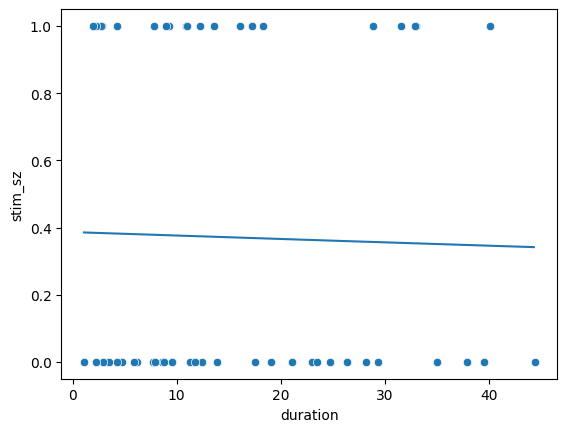

In [183]:
sns.scatterplot(x=data.duration,y=y)
x_plot = np.arange(data.duration.min(),data.duration.max(),.1)
sns.lineplot(x=x_plot,y=model.predict(np.concatenate((x_plot.reshape(-1,1),np.ones((len(x_plot),1))),axis=1)))